# Проект  c Bert

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
from pymystem3 import Mystem
import re
from textblob import TextBlob, Word
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import torch
import transformers
from tqdm import notebook
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:ylabel='Frequency'>

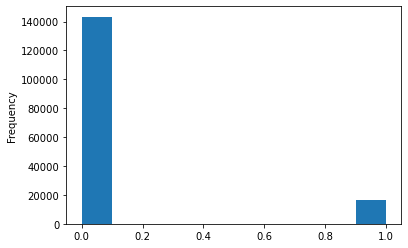

In [6]:
df['toxic'].plot(kind='hist')

Тест моделей без использования Bert

Лемматизация

In [7]:
corpus = df['text'].values.astype('U')

In [8]:
def clear_text(text):
    prom = re.sub(r'[^a-zA-Z]',' ', text).split()
    return ' '.join(prom)

In [9]:
def lemmatize(text):
    m = Mystem()
    return ''.join(m.lemmatize(text))


In [10]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a',
                "N": 'n',
                "V": 'v',
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [11]:
df['clear'] = df['text'].apply(clear_text)

In [12]:
df['lemm'] = df['clear'].apply(lemmatize_with_postag)

In [13]:
df.head()

,text,toxic,clear,lemm
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir be my hero Any chance you remember wha...


In [14]:
data = df.drop(['text', 'clear'], axis=1)
data.head()

,toxic,lemm
0,0,Explanation Why the edits make under my userna...
1,0,D aww He match this background colour I m seem...
2,0,Hey man I m really not try to edit war It s ju...
3,0,More I can t make any real suggestion on impro...
4,0,You sir be my hero Any chance you remember wha...


Тест с использование мешка слов

In [15]:
stop_words = set(stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)

In [16]:
features = count_vect.fit_transform(list(data['lemm']))
target = data['toxic']

Рассчет f1 для логистической регрессии

In [17]:
Logistic = LogisticRegression()
score_regr = round(cross_val_score(Logistic, features, target, cv=5, scoring='f1').mean(), 2)
print('f1 для логистической регрессии', score_regr)

Расчет f1 для CatBoostClassifier

In [18]:
cat = CatBoostClassifier(random_state=12345)
score_cat = round(cross_val_score(cat, features, target, cv=5, scoring='f1').mean(), 2)
print('Значение f1 для CatBoostClassifier', score_cat)

Тест с tf-idf

In [19]:
tf_idf_vect = TfidfVectorizer(stop_words=stop_words)
features_tf_idf = tf_idf_vect.fit_transform(list(data['lemm']))

Расчет f1 для логистической регрессии

In [20]:
regr = LogisticRegression()
score_regr_tf = round(cross_val_score(regr, features_tf_idf, target, cv=5, scoring='f1').mean(), 2)
print('Показаетель метрики f1 для логистической регрессии в случае с tf-idf', score_regr_tf)

Расчет f1 для CatBoostClassifier

In [21]:
cat = CatBoostClassifier(random_state=12345)
score_cat_tf = round(cross_val_score(cat, features_tf_idf, target, cv=2, scoring='f1').mean(), 2)
print('Показаетель метрики f1 для CatBoostClassifier в случае с tf-idf', score_cat_tf)

Тест с использование Bert

In [22]:
data_for_bert = df.drop(['lemm', 'text'], axis=1)
data_for_bert.head()

,toxic,clear
0,0,Explanation Why the edits made under my userna...
1,0,D aww He matches this background colour I m se...
2,0,Hey man I m really not trying to edit war It s...
3,0,More I can t make any real suggestions on impr...
4,0,You sir are my hero Any chance you remember wh...


In [23]:
data_for_bert = data_for_bert.sample(5000, random_state=12345).reset_index(drop=True)
data_for_bert.head()

,toxic,clear
0,1,Ahh shut the fuck up you douchebag sand nigger...
1,0,REPLY There is no such thing as Texas Commerce...
2,0,Reply Hey you could at least mention Jasenovac...
3,0,Thats fine there is no deadline chi
4,0,DYK nomination of Mustarabim Hello Your submis...


In [24]:
def less_than(string):
    if len(string) < 512:
        return string
    else:
        return string[0:512]

Обработка размера текста, так как Bert не работает с текстами, длина которых больше, чем 512

In [25]:
data_for_bert['clear'] = data_for_bert['clear'].apply(less_than)
data_for_bert

,toxic,clear
0,1,Ahh shut the fuck up you douchebag sand nigger...
1,0,REPLY There is no such thing as Texas Commerce...
2,0,Reply Hey you could at least mention Jasenovac...
3,0,Thats fine there is no deadline chi
4,0,DYK nomination of Mustarabim Hello Your submis...
...,...,...
4995,0,and since the speed of light is to be decided ...
4996,0,Gallup Poll The Gallup Poll appears in a secti...
4997,0,May I recommend though it may seem US centric ...
4998,0,REDIRECT Talk Lee Camp footballer


In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = data_for_bert['clear'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [27]:
model = transformers.BertModel.from_pretrained("bert-base-uncased")

In [28]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
features_bert = np.concatenate(embeddings)
target_bert = data_for_bert['toxic']

Тест для логистической регрессии

In [30]:
regr_for_bert = LogisticRegression()
regr_score_bert = round(cross_val_score(regr_for_bert, features_bert, target_bert, cv=4, scoring='f1').mean(), 2)
print('Показатели для логистической регрессии с использованием bert', regr_score_bert)

Тест для CatBoostRegressor

In [31]:
cat_for_bert = CatBoostClassifier(random_state=12345)
cat_score_bert = round(cross_val_score(cat_for_bert, features_bert, target_bert, cv=4, scoring='f1').mean(), 2)
print('Показатели для CatBoostClassifier с использованием bert', cat_score_bert)

Итоговая таблица

In [32]:
space = {'test':['CountVectorizer', 'CountVectorizer', 'tf-idf', 'tf-idf', 'bert', 'bert'],
         'model':['LogisticRegression', 'CatBoostClassifier']*3,
         'f1':[score_regr, score_cat, score_regr_tf, score_cat_tf, regr_score_bert, cat_score_bert]
         }
res = pd.DataFrame(data=space)

In [33]:
res

,test,model,f1
0,CountVectorizer,LogisticRegression,0.76
1,CountVectorizer,CatBoostClassifier,0.73
2,tf-idf,LogisticRegression,0.72
3,tf-idf,CatBoostClassifier,0.73
4,bert,LogisticRegression,0.65
5,bert,CatBoostClassifier,0.58


In [34]:
res.groupby(['test', 'model']).sum()

f1
test            model                   
CountVectorizer CatBoostClassifier  0.73
                LogisticRegression  0.76
bert            CatBoostClassifier  0.58
                LogisticRegression  0.65
tf-idf          CatBoostClassifier  0.73
                LogisticRegression  0.72

Исходя из полученных данных и проведенных тестов можно сказать, что наиболее эффективным оказалось применение логистической регрессии, обученной при помощи мешка слов, а применение модели bert только ухудшило показатели

Тестирование модели с наилучшими показателями

In [35]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [36]:
best_model = LogisticRegression()
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
score_test = round(f1_score(target_test, predictions), 2)
print('Результат проверки на тестовой выборке:',score_test)